# Machine Learning Project - Connect 4 Database

# HOUSSENALY Ali - GUILLARME Côme

This notebook presents the approach we took to exploit the UC Irvine Connect 4 Database.

We dive deeper in the data content and our objective once the visualisation is done.

In this notebook, you might be asked if you want to train or load models. This was done so that you don't have to train the models each time you reload the notebook.

## 0 - Import libraries and dataset

In [24]:
# Import modules
from ucimlrepo import fetch_ucirepo

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV


import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.svm import SVC


import os
import joblib


# Plotting style
ftsize_title = 20
ftsize_axis = 16
sns.set_style('whitegrid')
sns.set_palette("viridis")

In [2]:
# Fetch dataset from UCI repository
connect_4 = fetch_ucirepo(id=26)

## 1 - Understand the dataset

### 1a - Visualize the dataset

In [3]:
# Convert to DataFrame
df = pd.DataFrame(connect_4.data.features, columns=connect_4.feature_names)
df['target'] = connect_4.data.targets

# Display DataFrame information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67557 entries, 0 to 67556
Data columns (total 43 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   a1      67557 non-null  object
 1   a2      67557 non-null  object
 2   a3      67557 non-null  object
 3   a4      67557 non-null  object
 4   a5      67557 non-null  object
 5   a6      67557 non-null  object
 6   b1      67557 non-null  object
 7   b2      67557 non-null  object
 8   b3      67557 non-null  object
 9   b4      67557 non-null  object
 10  b5      67557 non-null  object
 11  b6      67557 non-null  object
 12  c1      67557 non-null  object
 13  c2      67557 non-null  object
 14  c3      67557 non-null  object
 15  c4      67557 non-null  object
 16  c5      67557 non-null  object
 17  c6      67557 non-null  object
 18  d1      67557 non-null  object
 19  d2      67557 non-null  object
 20  d3      67557 non-null  object
 21  d4      67557 non-null  object
 22  d5      67557 non-null

The dataset looks clean ! No missing values, no null values.

Let's represent a given row of the data

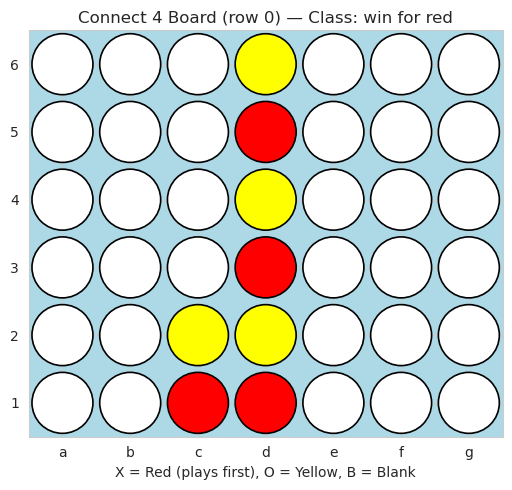

In [4]:
def visualize_connect4(df, row_index):
    """
    Visualize a Connect 4 board from a given row of the Connect4 dataset using matplotlib.
    
    Args:
        df (pd.DataFrame): The Connect4 dataset loaded as a pandas DataFrame.
        row_index (int): Index of the row to visualize.
    """
    # Extract the 42 board cells
    row = df.iloc[row_index, :42].values

    # Map values to colors
    color_map = {'x': 'red', 'o': 'yellow', 'b': 'white'}
    colors = np.array([color_map[val] for val in row])

    # Reshape into (6 rows, 7 columns)
    # Each column has 6 cells from bottom (1) to top (6)
    board = colors.reshape(7, 6).T  # shape (6,7)
    
    # Flip vertically to display row 6 at the top
    board = np.flipud(board)

    # Create figure
    fig, ax = plt.subplots(figsize=(6, 5))
    ax.set_aspect('equal')
    
    # Draw the grid and colored discs
    for r in range(6):
        for c in range(7):
            circle = plt.Circle((c, r), 0.45, color=board[r, c], ec='black', lw=1.2)
            ax.add_patch(circle)
    
    # Style grid
    ax.set_xlim(-0.5, 6.5)
    ax.set_ylim(-0.5, 5.5)
    ax.set_xticks(range(7))
    ax.set_xticklabels(list("abcdefg"))
    ax.set_yticks(range(6))
    ax.set_yticklabels(list(range(6, 0, -1)))
    ax.set_title(f"Connect 4 Board (row {row_index}) — Class: {df.iloc[row_index, 42]} for red")
    ax.set_xlabel('X = Red (plays first), O = Yellow, B = Blank')
    ax.set_facecolor('lightblue')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

visualize_connect4(df, 0)


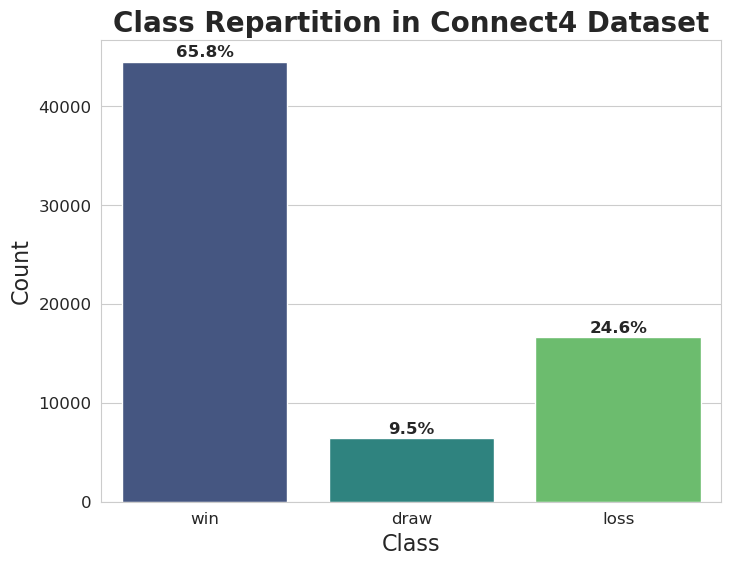

In [5]:
# Plot class distribution
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='target', data=df, palette='viridis', hue='target', dodge=False)

# Title and axis labels
plt.title('Class Repartition in Connect4 Dataset', fontsize=ftsize_title, fontweight='bold')
plt.xlabel('Class', fontsize=ftsize_axis)
plt.ylabel('Count', fontsize=ftsize_axis)
plt.xticks(fontsize=ftsize_axis-4)
plt.yticks(fontsize=ftsize_axis-4)

# Annotate each bar with percentage
total = len(df)
for p in ax.patches:
    height = p.get_height()
    percentage = f'{100 * height / total:.1f}%'
    ax.text(
        p.get_x() + p.get_width() / 2,
        height + 500,
        percentage,
        ha='center',
        fontsize=ftsize_axis - 4,
        fontweight='bold'
    )

plt.show()

We observe heavy class imbalance. We will have to deal with this in the model training part.

### 1b - Dataset understanding
From these representations, we understand better the dataset and our objective.

From the description of the dataset in UC Irvine we get : "*This database contains all legal 8-ply positions in the game of connect-4 in which neither player has won yet, and in which the next move is not forced. x is the first player; o the second. The outcome class is the game theoretical value for the first player.*"


This means that the dataset includes **every possible board configuration that can arise after exactly 8 legal moves** (plies) have been made, under these constraints:
- **Legal**: The moves follow the rules of Connect-4 — no floating discs, no overfilled columns.
- **No win yet**: Neither player has already won after 8 plies.
- **No forced move**: The next player has at least two legal options — i.e., they’re not forced to play in a single column.

Each position is labeled with its game-theoretical value (win, loss, or draw for player x), assuming **perfect play** from both sides.

From the example displayed above we see that red (ie player x) will win because he can place a disc in b1 or e1 and yellow (player o) will have to counter with respectively a1 or f1 leading red to victory because e1 or b1 will be open positions.

### 1c - Our objective
From this understanding we can define our objective : **Build a classification model that predicts the outcome (win, loss, or draw) for player x based on the board state**. This dataset is perfect for a supervised learning approach !

## 2 - Model Training on raw data: Naive Approach

Let's try to train models directly on the raw dataset. We will call this part the naive approach because we won't do any feature engineering or data rebalancing despite the heavy imbalance.

### 2a - Data Encoding and display function

In [6]:
# Useful display function
def performance_display(y_test, y_pred, title):
    """Function that displays a beautiful confusion matrix

    Args:
        y_test (pd.DataFrame): True label values of testing set
        y_pred (pd.DataFrame): Predicted label values of testing set
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted', fontsize=ftsize_axis)
    plt.ylabel('Actual', fontsize=ftsize_axis)
    # Invert y axis
    plt.gca().invert_yaxis()
    title = 'Confusion Matrix - ' + title
    plt.title(title, fontsize=ftsize_title, fontweight='bold')
    plt.show()
    
    # Print classification report
    report = classification_report(y_true=y_test, y_pred=y_pred)
    print('Classification Report:')
    print(report)

We have to encode our inputs. Indeed, ML models can't take as input string values like "x", "o" or "b". Therefore we encode that data.

Here we choose **One Hot Encoding**. This attributes a binary value for each of our category. 

Each feature is replaced by 3 features.
"x" --> (1, 0, 0)
"o" --> (0, 1, 0)
"b" --> (0, 0, 1)

We use this type of encoding instead of the more simple ordinal encoding because ordinal encoding can mislead models by introducing a false sense of order in the data.

In [ ]:
# Encode board positions
encoder = OneHotEncoder()
X_encoded = encoder.fit_transform(df.iloc[:, :42])
print(X_encoded.shape)
print(X_encoded.toarray()[:2])  # Display first 2 encoded rows
# Target
y = df['target']

# Train/test split
# We choose to stratify to ensure class proportions are maintained in both sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, stratify=y)

(67557, 126)
[[1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0.
  1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0.
  1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.
  1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0.
  1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0.
  1. 0. 0. 1. 0. 0.]
 [1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0.
  1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0.
  1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.
  0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0.
  1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0.
  1. 0. 0. 1. 0. 0.]]


### 2b - Random Forest

########### Training model ###########
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 3/5] END ..................n_estimators=200;, score=0.827 total time= 4.8min
[CV 5/5] END ..................n_estimators=200;, score=0.822 total time= 4.8min
[CV 4/5] END ..................n_estimators=200;, score=0.822 total time= 4.8min
[CV 1/5] END ..................n_estimators=200;, score=0.817 total time= 4.8min
[CV 2/5] END ..................n_estimators=200;, score=0.827 total time= 4.9min
########### Training complete ###########
Model saved to models/rf.pkl

Best parameters for Random Forest: {'n_estimators': 200}
Best score for Random Forest: 0.8230406678603037


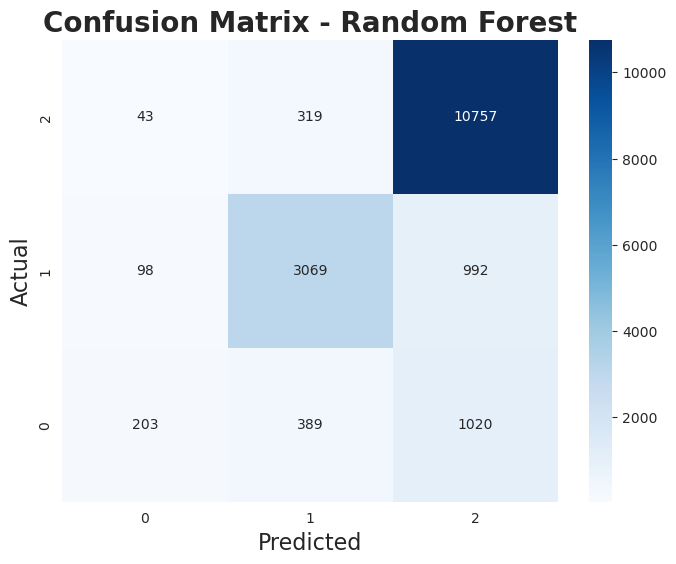

Classification Report:
              precision    recall  f1-score   support

        draw       0.59      0.13      0.21      1612
        loss       0.81      0.74      0.77      4159
         win       0.84      0.97      0.90     11119

    accuracy                           0.83     16890
   macro avg       0.75      0.61      0.63     16890
weighted avg       0.81      0.83      0.80     16890



In [22]:
choice = input("Do you want to train the Random Forest model or load it? (type 'train' or 'load'): ").strip().lower()
model_name = input("Enter Random Forest model filename to create or load (e.g., rf.pkl): ").strip()

model_path = os.path.join("models", model_name)


if choice == 'train':

    print("########### Training model ###########")

    # Define the parameter grid for Random Forest
    param_grid_rf = {
        'n_estimators': [200],
        # 'max_depth': [None, 10, 20, 30],
        # 'min_samples_split': [2, 5, 10],
        # 'min_samples_leaf': [1, 2, 4]
    }

    # Initialize the classifiers
    rf = RandomForestClassifier(random_state=42)

    # Initialize GridSearchCV for Random Forest
    grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, n_jobs=-1, verbose=3)

    # Perform grid search for Random Forest
    grid_search_rf.fit(X_train, y_train)
    print("########### Training complete ###########")

    # Save or overwrite
    joblib.dump(value=grid_search_rf.best_estimator_, filename=model_path)
    print(f"Model saved to {model_path}\n")

    print(f"Best parameters for Random Forest: {grid_search_rf.best_params_}")
    print(f"Best score for Random Forest: {grid_search_rf.best_score_}")

    # Evaluate the best Random Forest model on the test set
    best_rf = grid_search_rf.best_estimator_
    y_pred_rf = best_rf.predict(X_test)

    performance_display(y_test, y_pred_rf, "Random Forest")
    

elif choice == 'load':
    if os.path.exists(model_path):
        model = joblib.load(model_path)
        print(f"Model loaded from {model_path}")
        y_pred_rf = model.predict(X_test)
        performance_display(y_test, y_pred_rf, "Loaded Random Forest Model")
        
    else:
        print(f"No model found at {model_path}. Please train it first.")

else:
    print("Invalid choice. Please type 'train' or 'load'.")

### 2c - Support Vector Machine (SVM)

########### Training model ###########
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 5/5] END ...............C=10.0, kernel=poly;, score=0.848 total time=12.6min
[CV 1/5] END ...............C=10.0, kernel=poly;, score=0.837 total time=12.6min
[CV 4/5] END ...............C=10.0, kernel=poly;, score=0.846 total time=12.7min
[CV 2/5] END ...............C=10.0, kernel=poly;, score=0.849 total time=12.7min
[CV 3/5] END ...............C=10.0, kernel=poly;, score=0.843 total time=12.7min
########### Training complete ###########
Model saved to models/svm.pkl

Best parameters for SVM: {'C': 10.0, 'kernel': 'poly'}
Best score for SVM: 0.8446326576095847


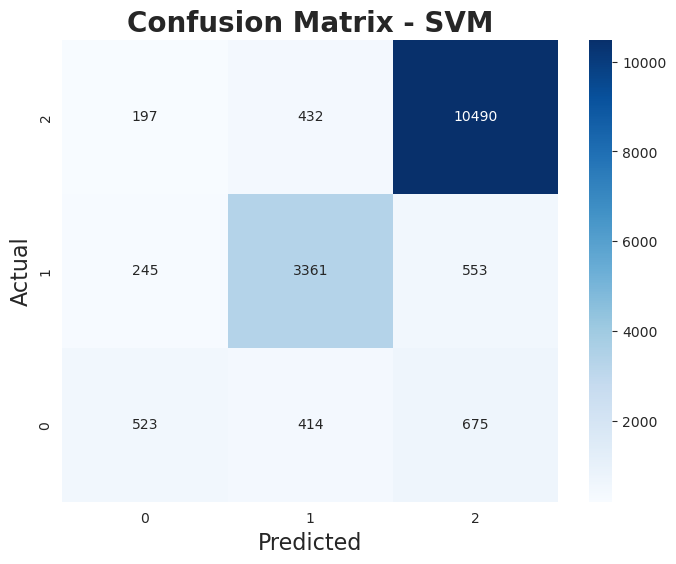

Classification Report:
              precision    recall  f1-score   support

        draw       0.54      0.32      0.41      1612
        loss       0.80      0.81      0.80      4159
         win       0.90      0.94      0.92     11119

    accuracy                           0.85     16890
   macro avg       0.75      0.69      0.71     16890
weighted avg       0.84      0.85      0.84     16890



In [21]:
choice = input("Do you want to train the SVM model or load it? (type 'train' or 'load'): ").strip().lower()
model_name = input("Enter SVM model filename to create or load (e.g., svm.pkl): ").strip()

model_path = os.path.join("models", model_name)

if choice == 'train':
    
    print("########### Training model ###########")

    # Define the parameter grid for SVM
    param_grid_svm = {
        # 'C': [0.1, 1.0, 10.0],  # Regularization parameter
        # 'kernel': ['rbf', 'poly', 'sigmoid']
        'C': [10.0],
        'kernel': ['poly']
    }

    # Initialize the classifier
    svm = SVC(random_state=42)

    # Initialize GridSearchCV for SVM
    grid_search_svm = GridSearchCV(estimator=svm, param_grid=param_grid_svm, cv=5, n_jobs=-1, verbose=3)

    # Perform grid search for SVM
    grid_search_svm.fit(X_train, y_train)
    print("########### Training complete ###########")

    # Save or overwrite
    joblib.dump(grid_search_svm.best_estimator_, model_path)
    print(f"Model saved to {model_path}\n")

    print(f"Best parameters for SVM: {grid_search_svm.best_params_}")
    print(f"Best score for SVM: {grid_search_svm.best_score_}")

    # Evaluate the best SVM model on the test set
    best_svm = grid_search_svm.best_estimator_
    y_pred_svm = best_svm.predict(X_test)

    performance_display(y_test, y_pred_svm, "SVM")

elif choice == 'load':
    if os.path.exists(model_path):
        model = joblib.load(model_path)
        print(f"Model loaded from {model_path}")
        y_pred_svm = model.predict(X_test)
        performance_display(y_test, y_pred_svm, "Loaded SVM Model")
        
    else:
        print(f"No model found at {model_path}. Please train it first.")

else:
    print("Invalid choice. Please type 'train' or 'load'.")

### 2d - XGBoost

In [28]:
from sklearn.preprocessing import LabelEncoder

# Encode y_train and y_test
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

########### Training model ###########
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/aliho/anaconda3/envs/myenv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [17:47:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/aliho/anaconda3/envs/myenv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [17:47:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/aliho/anaconda3/envs/myenv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [17:47:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/aliho/anaconda3/envs/myenv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [17:47:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/aliho/

[CV 4/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.8;, score=0.828 total time=   4.0s
[CV 2/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.8;, score=0.834 total time=   4.0s
[CV 5/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.8;, score=0.830 total time=   4.0s
[CV 1/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.8;, score=0.821 total time=   4.0s
[CV 3/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.8;, score=0.829 total time=   4.0s


/home/aliho/anaconda3/envs/myenv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [17:47:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


########### Training complete ###########
Model saved to models/xgb.pkl

Best parameters for XGBoost: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}
Best score for XGBoost: 0.828527487904067


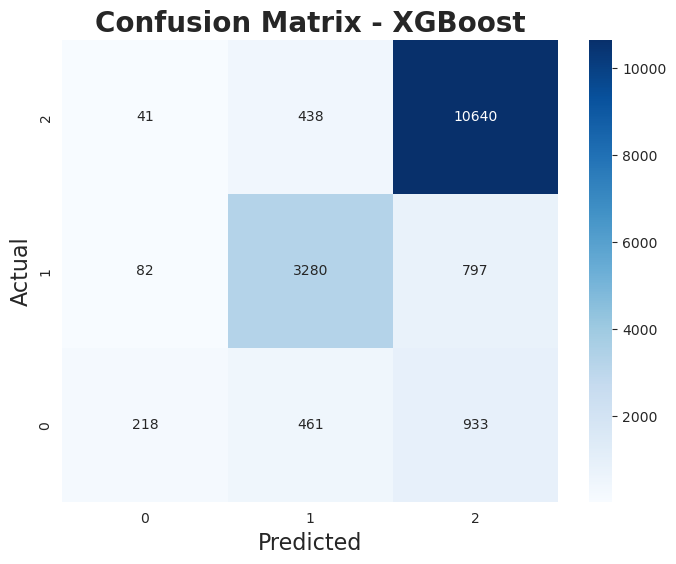

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.14      0.22      1612
           1       0.78      0.79      0.79      4159
           2       0.86      0.96      0.91     11119

    accuracy                           0.84     16890
   macro avg       0.76      0.63      0.64     16890
weighted avg       0.82      0.84      0.81     16890



In [ ]:
choice = input("Do you want to train the XGBoost model or load it? (type 'train' or 'load'): ").strip().lower()
model_name = input("Enter XGBoost model filename to create or load (e.g., xgb.pkl): ").strip()

model_path = os.path.join("models", model_name)

if choice == 'train':
    
    print("########### Training model ###########")

    # Define the parameter grid for XGBoost
    param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1],
    'max_depth': [4, 6, 8],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 5]
    }

    # Initialize the classifier
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

    # Initialize GridSearchCV for XGBoost
    grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, cv=5, n_jobs=-1, verbose=3)

    # Perform grid search for XGBoost
    grid_search_xgb.fit(X_train, y_train_encoded)
    print("########### Training complete ###########")

    # Save or overwrite
    joblib.dump(grid_search_xgb.best_estimator_, model_path)
    print(f"Model saved to {model_path}\n")

    print(f"Best parameters for XGBoost: {grid_search_xgb.best_params_}")
    print(f"Best score for XGBoost: {grid_search_xgb.best_score_}")

    # Evaluate the best XGBoost model on the test set
    best_xgb = grid_search_xgb.best_estimator_
    y_pred_xgb = best_xgb.predict(X_test)

    performance_display(y_test_encoded, y_pred_xgb, "XGBoost")

elif choice == 'load':
    if os.path.exists(model_path):
        model = joblib.load(model_path)
        print(f"Model loaded from {model_path}")
        y_pred_xgb = model.predict(X_test)
        performance_display(y_test, y_pred_xgb, "Loaded XGBoost Model")
        
    else:
        print(f"No model found at {model_path}. Please train it first.")

else:
    print("Invalid choice. Please type 'train' or 'load'.")

## 3 - Model training after handling data imbalance

## 4 - Model training after handling data imbalance and after performing feature engineering

## 5 - Overall comparison and conclusion